# Facial Keypoints Detection
## W207 Final Project December 2017
### Arunima Kayath, Kathleen Wang, Anamika Sinha & Scott A. George

In [1]:
import os

import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from decimal import *
import tensorflow as tf
import time
from datetime import datetime
import matplotlib.pyplot as plt
from tensorflow.contrib.layers import fully_connected

# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

## Loading Data

In [2]:
scott = False
aws = True
tensorboard_log = True

if scott:
    FROOT = ''
    FTRAIN = '/data/facial/training.csv'
    FTEST = '/data/facial/test.csv'
elif aws:
    FROOT = ''
    FTRAIN = '/data/training.csv'
    FTEST = '/data/test.csv'
else:
    FROOT = os.getcwd() # Path to your project folder
    FTRAIN = FROOT + '/data/training.csv'
    FTEST = FROOT + '/data/test.csv'

if tensorboard_log:
    root_logdir = FROOT + "tf_logs"

Helper function to load data

In [3]:
np.random.seed(0)
def load(test = False, cols = None):
    '''Loads data from FTEST if *test* is true, otherwise from FTRAIN.' 
    Pass a list of *cols* if you are only interested in a
    subset of the target columns'''
    
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname)) #load pandas dataframe

    
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im,sep=' ')) 
    #image column has pixel values separated by space; convert the values to numpy arrays
    
    if cols: #get a subset of columns
        df = df[list(cols) + ['Image']]
        
    print('Count of observations in training data by features')
    print(df.count()) #prints number of values for each column
    df = df.dropna() #drop all rows that have missing values in them
    
    X = np.vstack(df['Image'].values)/255
    X = X.astype(np.float32)
    
    if not test:
        y  = df[df.columns[:-1]].values
        y = (y-48)/48
        shuffle = np.random.permutation(np.arange(X.shape[0]))
        X, y = X[shuffle], y[shuffle]
        y = y.astype(np.float32)
    else:
        y = None
        
    return X,y


In [4]:
np.random.seed(0)
X, y = load()

print('Total training data')
print("X.shape = = {}; X.min == {:.3f}; X.max == {:.3f}".format(X.shape, X.min(),X.max()))
print("y.shape = = {}; y.min == {:.3f}; y.max == {:.3f}".format(y.shape, y.min(),y.max()))


Count of observations in training data by features
left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       22

Save 20% data to be used as dev data, carve out dev data and load test data

In [5]:
np.random.seed(0)
dev_size = 0.2
#setting aside a 20% sample for validation

x_train, x_dev, y_train, y_dev = train_test_split(X, y, test_size = dev_size)

x_test, _ = load(test=True)

print('Training data split into train and dev data')
print("x_train.shape = = {}; x_train.min == {:.3f}; x_train.max == {:.3f}".format(x_train.shape, x_train.min(),x_train.max()))
print("y_train.shape = = {}; y_train.min == {:.3f}; y_train.max == {:.3f}".format(y_train.shape, y_train.min(),y_train.max()))
print("x_dev.shape = = {}; x_dev.min == {:.3f}; x_dev.max == {:.3f}".format(x_dev.shape, x_dev.min(),x_dev.max()))
print("y_dev.shape = = {}; y_dev.min == {:.3f}; y_dev.max == {:.3f}".format(y_dev.shape, y_dev.min(),y_dev.max()))

Count of observations in training data by features
ImageId    1783
Image      1783
dtype: int64
Training data split into train and dev data
x_train.shape = = (1712, 9216); x_train.min == 0.000; x_train.max == 1.000
y_train.shape = = (1712, 30); y_train.min == -0.916; y_train.max == 0.996
x_dev.shape = = (428, 9216); x_dev.min == 0.000; x_dev.max == 1.000
y_dev.shape = = (428, 30); y_dev.min == -0.920; y_dev.max == 0.980


## Helper functions

### 1. plot_sample: plots sample pictures

In [6]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

In [7]:
np.random.seed(1)
def shuffle_run_batch(Xnp, ynp, Xdev, ydev, batch_size, epoch):
    """function takes training and dev data, shuffle the train data and run TF optimizer in batches for a given epoch
    It returns the average loss for training and eval of all the batches ran in the epoch.
    It expects to run with tensorboard."""

    shuffle = np.random.permutation(np.arange(Xnp.shape[0])) #shuffle the training data in each epoch
    Xnp, ynp = Xnp[shuffle], ynp[shuffle]

    # initialize variables to hold loss information for each epoch
    #loss_train = 0
    #loss_dev = 0
    batches = Xnp.shape[0]//batch_size


    for i in range(int(batches)): #run through most of the data points in each epoch
        X_batch,y_batch = Xnp[i*batch_size:(i+1)*batch_size,:], ynp[i*batch_size:(i+1)*batch_size]
        if tensorboard_log:
            if i % 10 == 0:
                train_summary_str = sqrt_loss_summary.eval(feed_dict={X: X_batch, y: y_batch, training: True})
                dev_summary_str = sqrt_loss_summary.eval(feed_dict={X: Xdev, y: ydev, training: False})
                step = epoch * batches + i
                train_writer.add_summary(train_summary_str, step)
                dev_writer.add_summary(dev_summary_str, step)

        sess.run(optimizer, feed_dict = {X:X_batch,y:y_batch, training:True})

    

        loss_train = loss.eval(feed_dict = {X:X_batch,y:y_batch,  training:True})            
        loss_dev = loss.eval(feed_dict = {X:Xdev,y:ydev, training:False})

    
    return loss_train, loss_dev
       
            

In [8]:
# *might* need to double check correctly formatted input
def plot_loss (train_loss_data, dev_loss_data):
    
    plt.plot(train_loss_data[:,1], label="train")
    plt.plot(dev_loss_data[:,1], linewidth=3, label="valid")
    plt.grid()
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.yscale("log")
    plt.show()

In [9]:
# *might* need to double check correctly formatted input
def plot_pred (x_dev, y_pred):
    
    fig = plt.figure(figsize=(16, 16))
    fig.subplots_adjust(
        left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(16):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        plot_sample(x_dev[i], y_pred[i], ax)
    plt.show
    


## First model: 1 hidden layer simple neural net

Define parameters

In [10]:
learning_rate = 0.01
momentum = 0.9

n_epochs = 500
batch_size = 50


n_inputs = X.shape[1] 
n_hidden1 = 100
n_outputs = 30


Construct the tensorflow graph for the first network

0 Train loss:0.139 Dev loss:0.141 ratio train/dev:0.99
10 Train loss:0.092 Dev loss:0.093 ratio train/dev:1.00
20 Train loss:0.078 Dev loss:0.085 ratio train/dev:0.92
30 Train loss:0.079 Dev loss:0.081 ratio train/dev:0.98
40 Train loss:0.068 Dev loss:0.077 ratio train/dev:0.88
50 Train loss:0.066 Dev loss:0.073 ratio train/dev:0.91
60 Train loss:0.063 Dev loss:0.070 ratio train/dev:0.91
70 Train loss:0.056 Dev loss:0.069 ratio train/dev:0.81
80 Train loss:0.053 Dev loss:0.068 ratio train/dev:0.78
90 Train loss:0.058 Dev loss:0.065 ratio train/dev:0.89
100 Train loss:0.055 Dev loss:0.064 ratio train/dev:0.85
110 Train loss:0.055 Dev loss:0.064 ratio train/dev:0.87
120 Train loss:0.048 Dev loss:0.062 ratio train/dev:0.78
130 Train loss:0.053 Dev loss:0.061 ratio train/dev:0.87
140 Train loss:0.051 Dev loss:0.062 ratio train/dev:0.82
150 Train loss:0.048 Dev loss:0.060 ratio train/dev:0.80
160 Train loss:0.046 Dev loss:0.061 ratio train/dev:0.75
170 Train loss:0.048 Dev loss:0.059 ratio 

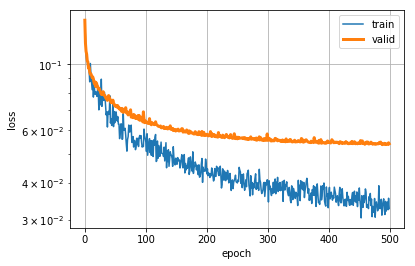

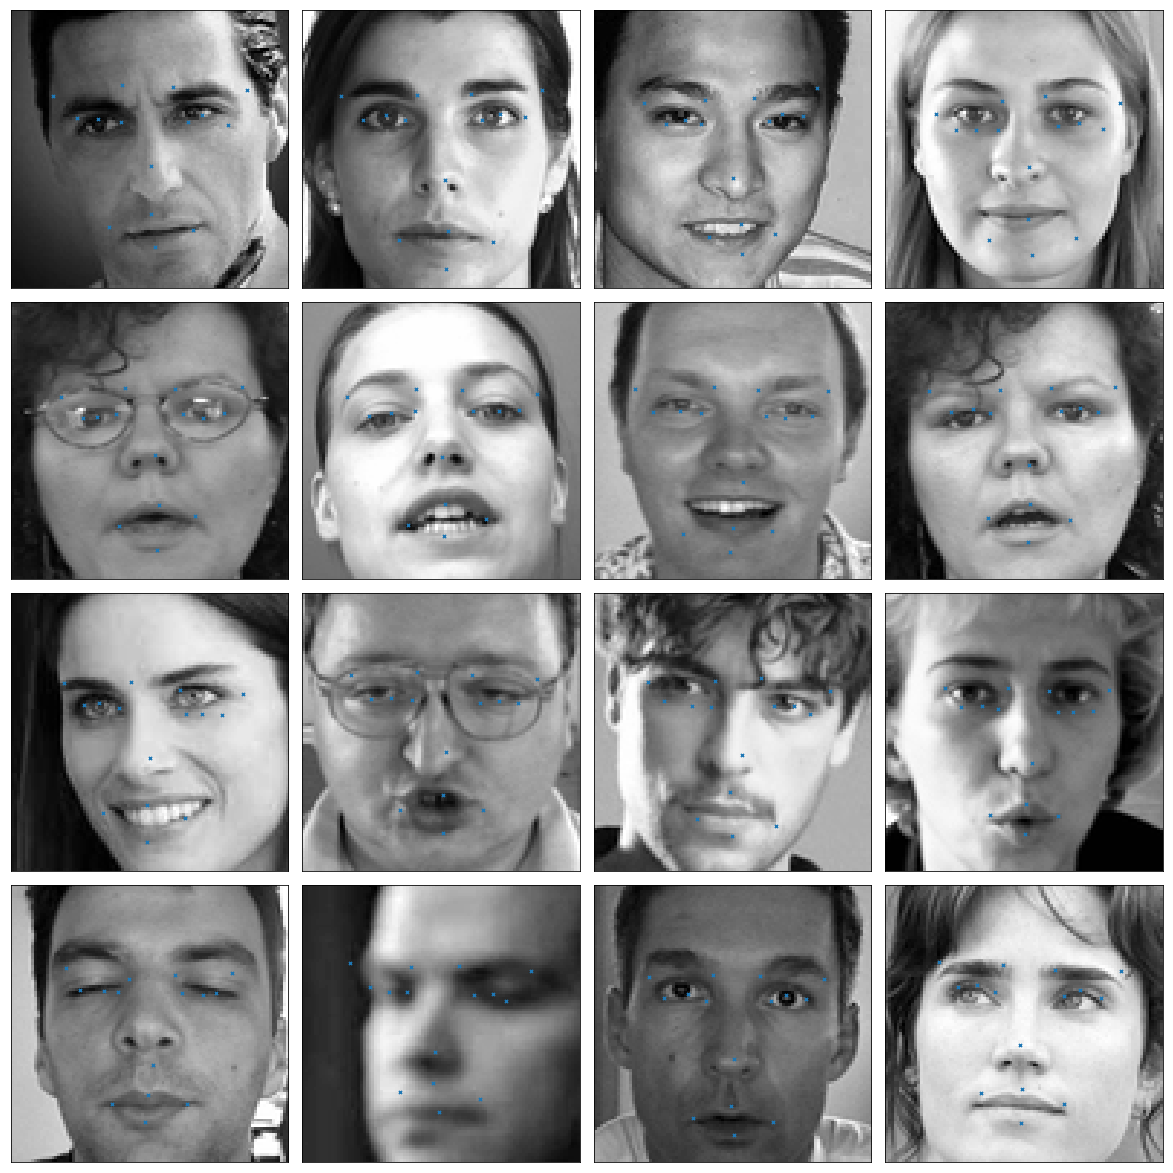

In [11]:
np.random.seed(1)
tf.reset_default_graph()

X = tf.placeholder(tf.float32,shape = (None,n_inputs),name = 'X')
y = tf.placeholder(tf.float32,shape = (None,n_outputs),name = 'y')
training = tf.placeholder(tf.bool)

if tensorboard_log:
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    logdir = "{}/run-{}/".format(root_logdir, now)


with tf.name_scope('dnn'):
    hidden1 = fully_connected(X,n_hidden1,scope = 'hidden1')
    pred_keypoints = fully_connected(hidden1,n_outputs,activation_fn = None,scope = 'outputs')
    
    
with tf.name_scope('loss'):
    loss = tf.reduce_mean(np.square(pred_keypoints - y))   
    sqrt_loss = tf.sqrt(loss)

with tf.name_scope('train'):
    optimizer = tf.train.MomentumOptimizer(learning_rate = learning_rate,momentum = momentum).minimize(loss) 
    #works better than gradientdescentoptimizer

#for tensorboard
with tf.name_scope('summaries'):
    sqrt_loss_summary = tf.summary.scalar('sqrt_loss', sqrt_loss)


if tensorboard_log:
    train_writer = tf.summary.FileWriter(logdir + '/train', tf.get_default_graph())
    dev_writer =  tf.summary.FileWriter(logdir + '/dev')
    
init = tf.global_variables_initializer()


train_loss_data = np.zeros((n_epochs,2))
dev_loss_data = np.zeros((n_epochs,2))

time_start = time.time()
time_1000_start = time.time()

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        
        # note this is includes the for-loop for batching
        loss_train,loss_dev = shuffle_run_batch (x_train, y_train, x_dev, y_dev, batch_size, epoch)
                    
        train_loss_data[epoch,:] = epoch,np.sqrt(loss_train)
        dev_loss_data[epoch,:] = epoch,np.sqrt(loss_dev)

            
        if epoch%10 == 0:
            print(epoch,'Train loss:%0.3f'%np.sqrt(loss_train),
                  'Dev loss:%0.3f'%np.sqrt(loss_dev),
                  'ratio train/dev:%0.2f'%np.sqrt(loss_train/loss_dev))
            
            
    time_end = time.time()  
    
    y_pred = sess.run(pred_keypoints,feed_dict = {X: x_test})
   
    print('Total time taken:',time_end-time_start)
    
train_writer.close()
dev_writer.close()
    
plt.figure()
plot_loss (train_loss_data, dev_loss_data)
plot_pred (x_dev, y_pred)


## Second model: Convolutional Neural Network

### 1. Base convolutional NN:
### optimizer = MomentumOptimizer, 
Define parameters

In [17]:
learning_rate = 0.01
momentum = 0.9
# optimizer used
optimize_func = tf.train.MomentumOptimizer
# (learning_rate = learning_rate,momentum = momentum,use_nesterov = True).minimize(loss)

n_epochs = 100
batch_size = 128

n_inputs = X.shape[1] 
n_outputs = 30


# Convolutional Layer 1.
filter_size1 = 3          # Convolution filters are 3 x 3 pixels.
num_filters1 = 32         # There are 32 of these filters.
dropout_keep_prob1 = 1


# Convolutional Layer 2.
filter_size2 = 2          # Convolution filters are 2 x 2 pixels.
num_filters2 = 64         # There are 64 of these filters.
dropout_keep_prob2 = 1


# Convolutional Layer 3.
filter_size3 = 2          # Convolution filters are 2 x 2 pixels.
num_filters3 = 128         # There are 128 of these filters.
dropout_keep_prob3 = 1


# Fully-connected layer.
fc_size4 = 1000             # Number of output neurons in fully-connected layer1.
dropout_keep_prob4 = 1      # Drop about keep robability if drop outs are applied
fc_size5 = 1000             # Number of output neurons in fully-connected layer2.
dropout_keep_prob5 = 1
dropout_keep_prob6 = 1



# # data_augmentation = False
# # learning_rate_decay = True
# # momentum_increase = True
# dropout = True

#model_name = "3con_2fc_b" + str(batch_size) + "_e" + str(num_epochs - 1)
# if data_augmentation:
#     model_name += "_aug"
# if learning_rate_decay:
#     model_name += "_lrdec"
# if momentum_increase:
#     model_name += "_mominc"
# if dropout:
#     model_name += "_dr"

### Define helper function to:   
### 1) create convoluted layer variables  
### 2) create dense layer and   
### 3) flatten a conv layer for the dense layer

In [18]:
#Building a convolutional layer

def new_conv_relu_layer(input, filter_size, num_filters, is_training, dropout_keep_prob = 1):
    """Takes parameters and set up a convoluted layer with possible pooling
    It returns the layer as well as the weights"""

    weights = tf.get_variable( 'weights', 
        shape = [filter_size, filter_size, input.get_shape()[3], num_filters],
        initializer = tf.contrib.layers.xavier_initializer()
      )
    
    biases = tf.get_variable( 'biases',
        shape = [num_filters],
        initializer=tf.constant_initializer(0.0)
      )
    
    conv = tf.nn.conv2d(input=input, filter=weights, strides=[1, 1, 1, 1], padding='SAME')
    
    
    layer = tf.nn.conv2d(input=input, filter=weights, strides=[1, 1, 1, 1], padding='SAME')


    layer += biases

    layer = tf.nn.max_pool(value=layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],padding='SAME')

    layer = tf.nn.relu(layer)    
    
    # apply drop out by specifying a drop_out_keep_prob
    layer = tf.cond(is_training, lambda: tf.nn.dropout(layer, keep_prob = dropout_keep_prob), lambda: layer)
    
    return layer, weights

In [19]:
#Building a fully connected layer, with relu
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu,
                 is_training ,
                 dropout_keep_prob = 1):       # no relu for the output dense layer

    # Create new weights and biases.
    weights = tf.get_variable( 'weights', 
        shape = [num_inputs, num_outputs],
        initializer = tf.contrib.layers.xavier_initializer()
      )
    
    biases = tf.get_variable( 'biases',
        shape = [num_outputs],
        initializer=tf.constant_initializer(0.0)
      )
        

    layer = tf.matmul(input, weights) + biases
    
    if use_relu:
        layer = tf.nn.relu(layer)
    
    layer = tf.cond(is_training, lambda: tf.nn.dropout(layer, keep_prob = dropout_keep_prob), lambda: layer)

    return layer

In [20]:
# build flatten layer function to flatten conv layer for the fully connected layer
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat, num_features

0 Train loss:0.150 Dev loss:0.150 ratio train/dev:1.00
5 Train loss:0.076 Dev loss:0.077 ratio train/dev:1.00
10 Train loss:0.074 Dev loss:0.072 ratio train/dev:1.03
15 Train loss:0.070 Dev loss:0.070 ratio train/dev:1.00
20 Train loss:0.073 Dev loss:0.068 ratio train/dev:1.07
25 Train loss:0.066 Dev loss:0.067 ratio train/dev:0.99
30 Train loss:0.073 Dev loss:0.066 ratio train/dev:1.10
35 Train loss:0.074 Dev loss:0.066 ratio train/dev:1.12
40 Train loss:0.069 Dev loss:0.066 ratio train/dev:1.05
45 Train loss:0.069 Dev loss:0.065 ratio train/dev:1.06
50 Train loss:0.063 Dev loss:0.065 ratio train/dev:0.97
55 Train loss:0.065 Dev loss:0.065 ratio train/dev:1.00
60 Train loss:0.064 Dev loss:0.065 ratio train/dev:0.99
65 Train loss:0.060 Dev loss:0.065 ratio train/dev:0.93
70 Train loss:0.067 Dev loss:0.065 ratio train/dev:1.03
75 Train loss:0.064 Dev loss:0.065 ratio train/dev:0.98
80 Train loss:0.061 Dev loss:0.064 ratio train/dev:0.94
85 Train loss:0.064 Dev loss:0.064 ratio train/dev

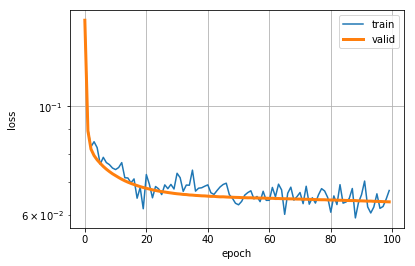

In [21]:
np.random.seed(1)
graph_base = tf.Graph()
with graph_base.as_default():

    if tensorboard_log:
        now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
        logdir = "{}/run-{}/".format(root_logdir, now)

    # def 
    # is_train = True
    #input data
    X = tf.placeholder(tf.float32,[None,X.shape[1]])
    y = tf.placeholder(tf.float32,[None,y.shape[1]])
    training = tf.placeholder(tf.bool)

    #convert x into 4-D input
    #2nd and 3rd dimension is image width and height, final dimension is number of color channels
    x_image = tf.reshape(X,[-1,96,96,1]) 

    #First convolutional layer
    with tf.variable_scope('conv1'):
        layer_conv1, weights_conv1 = new_conv_relu_layer (input = x_image, 
                                                          filter_size = filter_size1, 
                                                          num_filters = num_filters1, 
                                                          is_training = training,
                                                          dropout_keep_prob = dropout_keep_prob1)

    #Second convolutional layer
    with tf.variable_scope('conv2'):
        layer_conv2, weights_conv2 = new_conv_relu_layer (input = layer_conv1, 
                                                          filter_size = filter_size2, 
                                                          num_filters = num_filters2, 
                                                          is_training = training,
                                                          dropout_keep_prob = dropout_keep_prob2)

    #Thrid convolutional layer
    with tf.variable_scope('conv3'):
        layer_conv3, weights_conv3 = new_conv_relu_layer (input = layer_conv2, 
                                                          filter_size = filter_size3, 
                                                          num_filters = num_filters3, 
                                                          is_training = training,
                                                          dropout_keep_prob = dropout_keep_prob3)    

    #Flatten conv3 output for dense nn layer 1
    layer_flat, num_features = flatten_layer(layer_conv3)

    #Densely connected layer1
    with tf.variable_scope('fc4'):
        layer_fc4 = new_fc_layer(input =layer_flat,
                                num_inputs = num_features,
                                num_outputs = fc_size4,
                                use_relu = True,
                                is_training = training,
                                dropout_keep_prob = dropout_keep_prob4)

    #Densely connected layer2
    with tf.variable_scope('fc5'):
        layer_fc5 = new_fc_layer(input =layer_fc4,
                                num_inputs = fc_size4,
                                num_outputs = fc_size5,
                                use_relu = True,
                                is_training = training,
                                dropout_keep_prob = dropout_keep_prob5)    

    #Densely connected output layer
    with tf.variable_scope('fc6'):
        layer_f6 = new_fc_layer(input =layer_fc5,
                                num_inputs = fc_size5,
                                num_outputs = n_outputs,
                                use_relu = False,
                                is_training = training,
                                dropout_keep_prob = dropout_keep_prob6)       


    #loss function
    with tf.name_scope('loss'):
        loss = tf.reduce_mean(np.square(layer_f6 - y))
        sqrt_loss = tf.sqrt(loss)
        
    #for tensorboard
    with tf.name_scope('summaries'):
        sqrt_loss_summary = tf.summary.scalar('sqrt_loss', sqrt_loss)

        
    # optimizer
    optimizer = optimize_func(learning_rate = learning_rate,momentum = momentum,use_nesterov = True).minimize(loss)

    train_loss_data = np.zeros((n_epochs,2))
    dev_loss_data = np.zeros((n_epochs,2))
    y_pred = np.zeros((x_test.shape[0],y.shape[1]))

    # logger
    if tensorboard_log:
        train_writer = tf.summary.FileWriter(logdir + '/train', tf.get_default_graph())
        dev_writer =  tf.summary.FileWriter(logdir + '/dev')

    
time_start = time.time()
time_1000_start = time.time()

    
with tf.Session(graph=graph_base) as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(n_epochs):
        #print('starting epoch:',epoch)
        
        loss_train,loss_dev = shuffle_run_batch (x_train, y_train, x_dev, y_dev, batch_size, epoch)

        train_loss_data[epoch,:] = epoch,np.sqrt(loss_train)
        dev_loss_data[epoch,:] = epoch,np.sqrt(loss_dev)

        
        if epoch%5 == 0:
            print(epoch,'Train loss:%0.3f'%np.sqrt(loss_train),'Dev loss:%0.3f'%np.sqrt(loss_dev),'ratio train/dev:%0.2f'%np.sqrt(loss_train/loss_dev))
        
    time_end = time.time()
    print('Total time taken:',time_end-time_start)
    
    for i in range(int(x_test.shape[0]//batch_size)): #doing predictions in batches
            X_batch = x_test[i*batch_size:(i+1)*batch_size,:]
            y_pred [i*batch_size:(i+1)*batch_size] = sess.run(layer_f6,feed_dict = {X:X_batch, training:False})

#Plot a graph of the train vs test loss data:
    

plot_loss (train_loss_data, dev_loss_data)


train_writer.close()
dev_writer.close()
# plot_pred (x_test, y_pred)

# #Examine a few test cases to see accuracy of prediction:
# def plot_sample(x, y, axis):
#     img = x.reshape(96, 96)
#     axis.imshow(img, cmap='gray')
#     axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

# fig = plt.figure(figsize=(16, 16))
# fig.subplots_adjust(
#     left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# for i in range(16):
#     ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
#     plot_sample(X_test[i], y_pred[i], ax)

# plt.show()

